## Imports

In [1]:
from azure.cosmos.exceptions import CosmosResourceExistsError
import azure.cosmos.cosmos_client as cosmos_client
from azure.cosmos.partition_key import PartitionKey

from dotenv import dotenv_values
from BagOfWords import BOW
from nb import NaiveBayes

from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andyhuynh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 ## Data Initialization
Here, we build our dataset using Bag of Words to initialize our 'X' and 'Y' arrays.

In [5]:
# config = dotenv_values('.env')
# client = cosmos_client.CosmosClient(
#     config['AZURE_SQL_HOST'],
#     {
#         'masterKey': config['AZURE_SQL_MASTER_KEY']
#     },
#     user_agent="CosmosDBPythonQuickstart",
#     user_agent_overwrite=True
# )
# db = client.create_database_if_not_exists(id=config['AZURE_SQL_DATABASE_ID'])
# print('Database with id \'{0}\' initialized'.format(config['AZURE_SQL_DATABASE_ID']))
# container = db.create_container_if_not_exists(
#     id=config['AZURE_SQL_CONTAINER_ID'],
#     partition_key=PartitionKey(path='/ethical_tag'),
#     offer_throughput=1000
# )
# nb = NaiveBayes()
# print('Container with id \'{0}\' initialized'.format(config['AZURE_SQL_CONTAINER_ID']))

# items = container.read_all_items()

Database with id 'ethiclassifier' initialized
Container with id 'data' initialized


In [2]:
config = dotenv_values('.env')
client = cosmos_client.CosmosClient(
    config['AZURE_SQL_HOST'],
    {
        'masterKey': config['AZURE_SQL_MASTER_KEY']
    },
    user_agent="CosmosDBPythonQuickstart",
    user_agent_overwrite=True
)
db = client.create_database_if_not_exists(id=config['AZURE_SQL_DATABASE_ID'])
print('Database with id \'{0}\' initialized'.format(config['AZURE_SQL_DATABASE_ID']))
container = db.create_container_if_not_exists(
    id=config['AZURE_SQL_CONTAINER_ID'],
    partition_key=PartitionKey(path='/ethical_tag'),
    offer_throughput=1000
)
nb = NaiveBayes()
print('Container with id \'{0}\' initialized'.format(config['AZURE_SQL_CONTAINER_ID']))

items = container.read_all_items()
items = list(items)

Database with id 'ethiclassifier' initialized
Container with id 'data' initialized


This cell is where we build the dataset we'll be using for our models. Since we have so much more ethical data than unethical data, we gave ourselves the ability to limit the amount of ethical data we use in our dataset. ethicals_full will have around 27,000 entries, while unethicals (unlimited) will have around 2,400.
We also use np.random.shuffle() to make sure the our models don't just learn patterns in the order of the dataset.

In [4]:
ethicals_full = [item for item in items if item['ethical_tag']]
ethicals = ethicals_full[:2472]

unethicals = [item for item in items if not item['ethical_tag']]

# Build the dataset with the data entries we get from the 'items' list.
dataset = ethicals + unethicals
np.random.seed(69420)
np.random.shuffle(dataset)
print("Total dataset has", len(dataset), "entries.")

Total dataset has 4944 entries.


## Complement Naive Bayes & Logistic Regression
This is where we build our machine learning models. We first pass our dataset through a TFIDF vectorizer, which functions similarly to Bag of Words: it takes text input and "vectorizes" it, converting words to numerical data that we can pass in to our models.

We split the data into training sets and testing sets; our models train on 80% of the total data, and then we use the remaining 20% as validation.

In [6]:

X = list(map(lambda x: x["text"], dataset))
vectorizer = TfidfVectorizer(stop_words='english')

logreg = LogisticRegression(penalty='l2')
pipe = Pipeline([('vec', vectorizer), ('logreg', logreg)])

cnb = ComplementNB()
pipe2 = Pipeline([('vec', vectorizer), ('cnb', cnb)])

y = list(map(lambda x: x["ethical_tag"], dataset))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

pipe.fit(X_train, y_train)
acc1 = pipe.score(X_test, y_test)
cv1 = np.mean(cross_val_score(pipe, X, y, cv=5))
pred_logreg = pipe.predict(X_test)

pipe2.fit(X_train, y_train)
acc2 = pipe2.score(X_test, y_test)
cv2 = np.mean(cross_val_score(pipe2, X, y, cv=5))
pred_cnb = pipe2.predict(X_test)

print("Logistic Regression accuracy:", acc1, "\nNaive Bayes accuracy:", acc2)

Logistic Regression accuracy: 0.8068756319514662 
Naive Bayes accuracy: 0.7917087967644085


In [9]:
grid_params = {
  'alpha': np.linspace(0.01, 0.05, 2),
  'hidden_layer_sizes': [(10,10,5)],
  'learning_rate_init': np.linspace(0.1, 0.5, 2),
  'activation': ['tanh', 'relu'],
}

mlp = MLPClassifier(max_iter=50)
model = GridSearchCV(mlp, grid_params)

pipeNN = Pipeline([('vec', vectorizer), 
                        ('nn', model)])

# cv2 = np.mean(cross_val_score(pipeNN, X, y, cv=5))
# print(cv2)

In [10]:
train = dataset[:int((0.8)*len(dataset))]
test = dataset[int((0.8)*len(dataset)):]

bow_train = BOW(train)
trainX = bow_train.X
trainY = bow_train.y

bow_test = BOW(test)
testX = bow_test.X
testY = bow_test.y
# print(np.stack([testY, pred]))

In [11]:
cnb = ComplementNB()
cnb.fit(trainX, trainY)

pred = cnb.predict(testX)
diffs = testY ^ pred
error_pct = sum(diffs) / len(pred)
print("error percent: " + str(error_pct))
mse = mean_squared_error(1 * testY, 1 * pred)
print("mse: " + str(mse))

scores = cross_val_score(cnb, np.concatenate((trainX, testX)), np.concatenate((trainY, testY)), cv=5)
avg_acc = np.mean(scores)
print(avg_acc)

error percent: 0.4590495449949444
mse: 0.4590495449949444
0.6528907046335604


In [12]:
# we used l2 penalty as we have colinear / codependent features 
logreg = LogisticRegression(penalty='l2')
logreg.fit(trainX, trainY)
print(pred.shape, testY.shape)
diffs = testY ^ pred
error_pct = sum(diffs) / len(pred)
print("error percent: " + str(error_pct))
mse = mean_squared_error(1 * testY, 1 * pred)
print("mse: " + str(mse))

scores = cross_val_score(logreg, np.concatenate((trainX, testX)), np.concatenate((trainY, testY)), cv=5)
avg_acc = np.mean(scores)
print(avg_acc)

(989,) (989,)
error percent: 0.4590495449949444
mse: 0.4590495449949444
0.6919323080197967


In [13]:
ulpt = "Flying on your employer's dime? Book an expensive flight, then call the airline later to change for a cheaper fare (ie earlier/later the same day). Ask for the travel credit to be sent to your personal email. Use it later for personal travel. Your employer will not know."
lpt = "I'm 43. By your late 20's/early 30's, make sure physical fitness becomes an absolute top priority. I started a dedicated fitness regimen when I was 28 to improve my odds with a girl. Didn't work on the girl. What did work was that the routine stuck. Now pushing my mid-forties, I can't believe where I am physically compared to many others my age. Also scary is how they regard physical deterioration as an inevitability. It isn't. Get started now. It will be one of the greatest gifts you'll ever give yourself."

# ulpt = "donate to charities"

data = [ulpt, lpt]
print(pipe.predict(data))

[False  True]


# Graphs & Plots

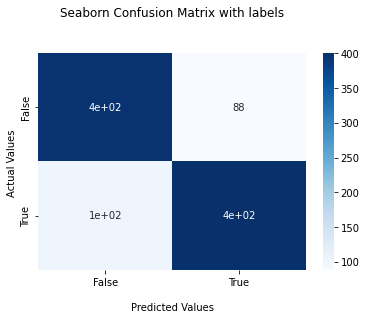

In [164]:
from plots import plot
from PIL import Image
import pandas as pd

plotter = plot(y_test, pred_logreg)
plotter.fpr_fnr()

items = vectorizer.idf_
idx = np.argsort(items)
scores = list(np.array(items)[idx])

N_words = 100

feature_names = vectorizer.get_feature_names_out()
topN = np.flip(np.argsort(logreg.coef_))[:, :N_words]

features = feature_names[topN].reshape(N_words)
weights = logreg.coef_[:, topN].reshape(N_words)
topN = dict(zip(features.tolist(), weights.tolist()))

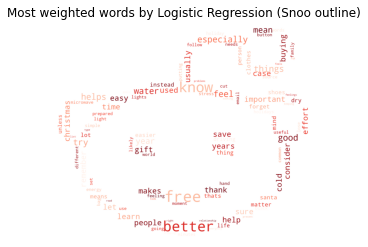

In [172]:
reddit_mask = np.array(Image.open('../images/reddit-logo.jpg'))
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib as plt

# from https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214

# A similar function, but using the mask
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=100,
                      colormap='Reds',
                      mask=mask,
                      width = 1600,
                      height = 800,
                      background_color='white',
                      collocations=True).generate_from_frequencies(topN)
    
    plt.figure.Figure(figsize=(20,10), dpi=500)
    plt.pyplot.imshow(cloud)
    plt.pyplot.axis('off')
    plt.pyplot.title(title)
    plt.pyplot.show()
    
# Use the function with the rome_corpus and our mask to create word cloud     
generate_better_wordcloud(data, title = 'Most weighted words by Logistic Regression (Snoo outline)', mask=reddit_mask)